# Random Features Experiments

In [ ]:
#!pip install kaggle kagglehub

In [1]:
# Importing the necessary libraries
import kagglehub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.kernel_approximation import RBFSampler, Nystroem
from sklearn.linear_model import Ridge
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

## 1. The Data
### A. Dataset Retrieval
- Forest Cover: This dataset, also known as "Covertype," contains information about forest plots in the United States, with the goal of predicting the type of forest cover.

In [2]:
# ----------------------
# Loading the Data
# ----------------------

# Download the latest version of the dataset
path = kagglehub.dataset_download("uciml/forest-cover-type-dataset")
print("Path to dataset files:", path)

# Load the file
file_path = "/root/.cache/kagglehub/datasets/uciml/forest-cover-type-dataset/versions/1/covtype.csv"
df = pd.read_csv(file_path)

Path to dataset files: /root/.cache/kagglehub/datasets/uciml/forest-cover-type-dataset/versions/1


### B. Data Exploration

In [ ]:
# Preview of the first rows
print(df.head())

# General information about the data
print(df.info())

# Check for missing values
print(df.isnull().sum())

   Elevation  Aspect  Slope  Horizontal_Distance_To_Hydrology  \
0       2596      51      3                               258   
1       2590      56      2                               212   
2       2804     139      9                               268   
3       2785     155     18                               242   
4       2595      45      2                               153   

   Vertical_Distance_To_Hydrology  Horizontal_Distance_To_Roadways  \
0                               0                              510   
1                              -6                              390   
2                              65                             3180   
3                             118                             3090   
4                              -1                              391   

   Hillshade_9am  Hillshade_Noon  Hillshade_3pm  \
0            221             232            148   
1            220             235            151   
2            234             238   

The Forest Cover Type dataset has been successfully loaded. Here are the key observations:

- It contains 581,012 observations and 55 columns.
- No missing values (isnull().sum() returns only zeros).
- The columns include:
  - Continuous variables: Elevation, Aspect, Slope, Hillshade, Distance (to water, roads, and fire).
  - Binary variables: Wilderness_Area1-4, Soil_Type1-40.
  - Target variable (Cover_Type): Represents 7 different forest cover types.

### C. Data Preprocessing
Before applying Random Fourier Features (RFF), we perform the following transformations:

- Separate the features (X) and the target variable (y).
- Standardize numerical variables to improve model convergence.
- Create a train/test split.

In [4]:
# -------------------------
# Data Preprocessing
# -------------------------

# Separate features and target
X = df.drop(columns=["Cover_Type"])  # Remove the target column
y = df["Cover_Type"]  # Target

# Standardize only continuous columns
num_cols = ["Elevation", "Aspect", "Slope", "Horizontal_Distance_To_Hydrology",
            "Vertical_Distance_To_Hydrology", "Horizontal_Distance_To_Roadways",
            "Hillshade_9am", "Hillshade_Noon", "Hillshade_3pm",
            "Horizontal_Distance_To_Fire_Points"]

#scaler = StandardScaler()
#X[num_cols] = scaler.fit_transform(X[num_cols])  # Standardization

scaler = MinMaxScaler()
X[num_cols] = scaler.fit_transform(X[num_cols])

# Split into train/test (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Display dimensions
print(f"Train: {X_train.shape}, Test: {X_test.shape}")


Train: (464809, 54), Test: (116203, 54)


## 2. Implementation of Methods
### A. SVM with RBF Kernel
Let's start by running an SVM with an RBF kernel.

In [5]:
# ----------------------------
# Implementation of Methods
# ----------------------------

# 2.1 Standard SVM with RBF Kernel
def train_svm():
    svm = SVC(kernel='rbf', C=1.0)  # Standard SVM model

    # Training
    start_train = time.time()
    svm.fit(X_train, y_train)
    train_time = time.time() - start_train

    # Prediction
    start_pred = time.time()
    y_pred = svm.predict(X_test)
    pred_time = time.time() - start_pred

    # Evaluation
    accuracy = accuracy_score(y_test, y_pred)

    return accuracy, train_time, pred_time

### B. Random Fourier Features
The paper proposes an approximation of Gaussian kernels using Random Fourier Features (RFF). We will now:

1. Generate Random Fourier Features (RFF) to approximate a Gaussian kernel.
2. Transform the training and test data.
3. Train a Ridge Regression model on the transformed features.
4. the model using an error metric.

In [6]:
# 2.2 RFF + Ridge Regression
def train_rff_ridge(D, gamma, alpha):
    rff = RBFSampler(gamma=gamma, n_components=D, random_state=42)
    ridge = Ridge(alpha=alpha)

    start_train = time.time()
    X_train_rff = rff.fit_transform(X_train)
    X_test_rff = rff.transform(X_test)
    ridge.fit(X_train_rff, y_train)
    train_time = time.time() - start_train

    start_pred = time.time()
    y_pred = ridge.predict(X_test_rff)
    y_pred_class = np.round(y_pred).astype(int)
    pred_time = time.time() - start_pred

    accuracy = accuracy_score(y_test, y_pred_class)

    return accuracy, train_time, pred_time

In [13]:
accuracy, train_time, pred_time = train_rff_ridge(D=500, gamma=1.0, alpha=0.1)

print(f"Accuracy of Ridge Regression with RFF: {accuracy:.4f}")

Accuracy de Ridge Regression avec RFF: 0.4601


Result: 46.01% accuracy

This is not yet optimal, but it's a good starting point! The paper achieves better performance, so we can try to improve our model.

We will now test different values for n_components, gamma, and alpha.

In [18]:
# Optimal parameters found
D = 2000  # Fixed as the best value
gamma_list = [0.05, 0.1, 0.2]  # Fine-tuning gamma
alpha_list = [0.1, 1.0, 10]  # Fine-tuning alpha

best_accuracy = 0
best_params = {}

for gamma in gamma_list:
    for alpha in alpha_list:
        # Apply Random Fourier Features (RFF)
        accuracy, train_time, pred_time = train_rff_ridge(D=D, gamma=gamma, alpha=alpha)

        # Save the best model
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_params = {"gamma": gamma, "alpha": alpha}

        print(f"gamma={gamma}, alpha={alpha} → Accuracy: {accuracy:.4f}")

# Final result
print("\nBest combination:")
print(f"gamma={best_params['gamma']}, alpha={best_params['alpha']} → Accuracy: {best_accuracy:.4f}")

gamma=0.05, alpha=0.1 → Accuracy: 0.6166
gamma=0.05, alpha=1.0 → Accuracy: 0.6075
gamma=0.05, alpha=10 → Accuracy: 0.5799
gamma=0.1, alpha=0.1 → Accuracy: 0.6027
gamma=0.1, alpha=1.0 → Accuracy: 0.6031
gamma=0.1, alpha=10 → Accuracy: 0.5893
gamma=0.2, alpha=0.1 → Accuracy: 0.5729
gamma=0.2, alpha=1.0 → Accuracy: 0.5731
gamma=0.2, alpha=10 → Accuracy: 0.5732

Meilleure combinaison :
gamma=0.05, alpha=0.1 → Accuracy: 0.6166


After testing the influence of several parameters, we found that the one with the greatest impact on accuracy is D. Indeed, the higher its value, the better the results obtained.

Studying the Impact of the Number of Features (n_components) on Computational Time – Why?
- Rahimi & Recht explain that the approximation improves as the number of n_components increases.
- However, this also increases computational cost.

To determine the best trade-off, we will:

- Plot a graph of Accuracy vs. n_components and Computation Time vs. n_components.
Action Plan:
- Test different values of n_components and measure training and prediction time.
- Display a graph comparing accuracy and computation time as a function of n_components.


D=500 → Accuracy: 0.5347, Temps d'entraînement: 10.0186 sec
D=1000 → Accuracy: 0.5793, Temps d'entraînement: 20.3524 sec
D=2000 → Accuracy: 0.6166, Temps d'entraînement: 42.7337 sec
D=4000 → Accuracy: 0.6532, Temps d'entraînement: 98.2309 sec
D=8000 → Accuracy: 0.6724, Temps d'entraînement: 238.4254 sec


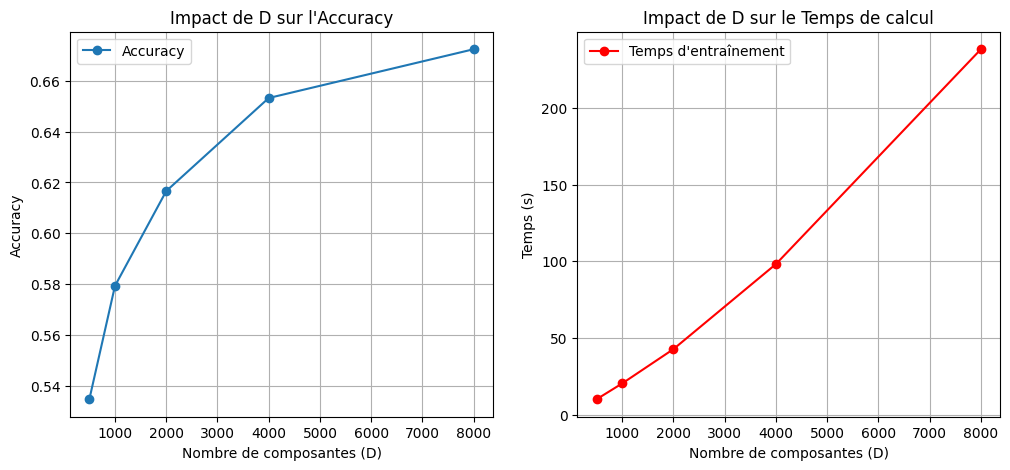

In [21]:
# Optimal parameters found
gamma = 0.05  # Optimal value found
alpha = 0.1   # Optimal value found

# List of D (n_components) values to test
D_list = [500, 1000, 2000, 4000, 8000]
accuracies = []
train_times = []

# Verify that the function is defined before executing it
if "train_rff_ridge" not in globals():
    raise NameError("The function train_rff_ridge() is not defined. Make sure it exists.")

for D in D_list:
    accuracy, train_time, pred_time = train_rff_ridge(D=D, gamma=gamma, alpha=alpha)

    accuracies.append(accuracy)
    train_times.append(train_time)

    print(f"D={D} → Accuracy: {accuracy:.4f}, Training time: {train_time:.4f} sec")

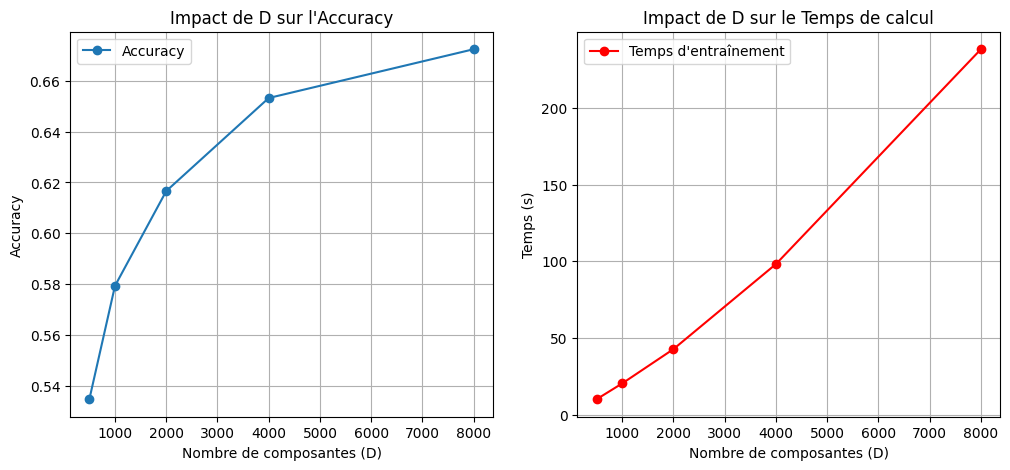

In [22]:
# Plotting results
plt.figure(figsize=(12,5))

# Graph 1: Accuracy as a function of D
plt.subplot(1,2,1)
plt.plot(D_list, accuracies, marker='o', label="Accuracy")
plt.xlabel("Number of components (D)")
plt.ylabel("Accuracy")
plt.title("Impact of D on Accuracy")
plt.grid()
plt.legend()

# Graph 2: Training time as a function of D
plt.subplot(1,2,2)
plt.plot(D_list, train_times, marker='o', color='red', label="Training time")
plt.xlabel("Number of components (D)")
plt.ylabel("Time (s)")
plt.title("Impact of D on Computation Time")
plt.grid()
plt.legend()

plt.show()

### C. Random Binning Features
The paper by Rahimi & Recht introduces Random Binning Features (RBF) as another approximation of the RBF kernel. The idea is to partition the input space into random bins and use these partitions to approximate the kernel function.

Objective:
Compare RFF, RBF (Binning), SVM with RBF kernel, and exact CVM in terms of:

Accuracy
Training time
Prediction time



In [7]:
# 2.3 Random Binning Features (RBF) + Ridge Regression
def train_rbf_ridge(P, gamma, alpha):
    rbf = Nystroem(kernel='rbf', gamma=gamma, n_components=P, random_state=42)
    ridge = Ridge(alpha=alpha)

    start_train = time.time()
    X_train_rbf = rbf.fit_transform(X_train)
    X_test_rbf = rbf.transform(X_test)
    ridge.fit(X_train_rbf, y_train)
    train_time = time.time() - start_train

    start_pred = time.time()
    y_pred = ridge.predict(X_test_rbf)
    y_pred_class = np.round(y_pred).astype(int)
    pred_time = time.time() - start_pred

    accuracy = accuracy_score(y_test, y_pred_class)

    return accuracy, train_time, pred_time

D. CVM

In [8]:
# 2.4 CVM Approximation with Subsampled SVM
def train_cvm(sample_size=5000):
    idx = np.random.choice(X_train.shape[0], size=sample_size, replace=False)
    X_train_sampled = X_train.iloc[idx]
    y_train_sampled = y_train.iloc[idx]

    svm = SVC(kernel='rbf', C=1.0)

    start_train = time.time()
    svm.fit(X_train_sampled, y_train_sampled)
    train_time = time.time() - start_train

    start_pred = time.time()
    y_pred = svm.predict(X_test)
    pred_time = time.time() - start_pred

    accuracy = accuracy_score(y_test, y_pred)

    return accuracy, train_time, pred_time

## Comparison of Methods

In [ ]:
# Optimal parameters from the paper
D = 5000  # Components for RFF
P = 50    # Partitions for RBF
gamma = 0.05  # Kernel parameter
alpha = 0.1   # Ridge regularization parameter

# Running the tests
acc_rff, train_t_rff, pred_t_rff = train_rff_ridge(D, gamma, alpha)
acc_rbf, train_t_rbf, pred_t_rbf = train_rbf_ridge(P, gamma, alpha)
accuracy_svm, train_time_svm, pred_time_svm = train_svm()
accuracy_cvm, train_time_cvm, pred_time_cvm = train_cvm()

# Summary of results
labels = ["RFF + Ridge", "RBF + Ridge", "SVM RBF", "CVM"]
"""accuracies = [acc_rff, acc_rbf, accuracy_cvm]
train_times = [train_t_rff, train_t_rbf, train_time_cvm]
pred_times = [pred_t_rff, pred_t_rbf, pred_time_cvm]"""
accuracies = [acc_rff, acc_rbf, accuracy_svm, accuracy_cvm]
train_times = [train_t_rff, train_t_rbf, train_time_svm, train_time_cvm]
pred_times = [pred_t_rff, pred_t_rbf, pred_time_svm, pred_time_cvm]

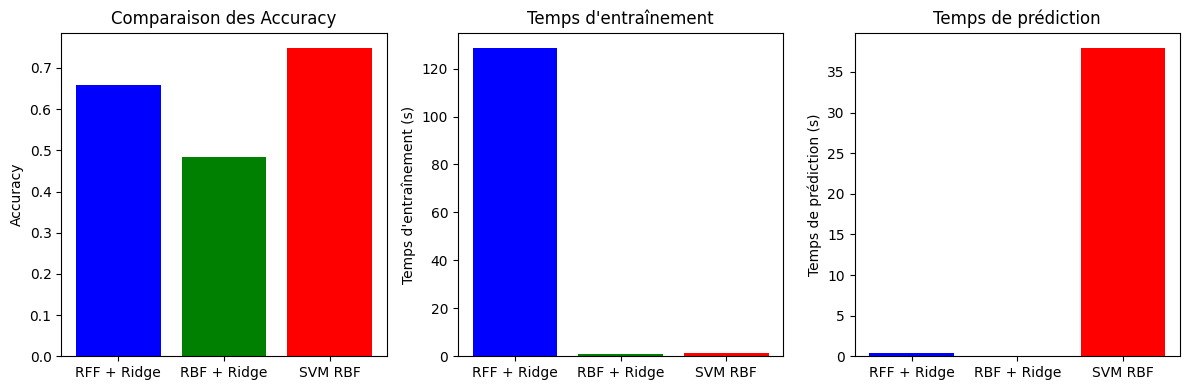

In [10]:
# ------------------------------------
# Visualization of Results
# ------------------------------------

labels = ["RFF + Ridge", "RBF + Ridge", "SVM RBF"]
accuracies = [acc_rff, acc_rbf, accuracy_cvm]
train_times = [train_t_rff, train_t_rbf, train_time_cvm]
pred_times = [pred_t_rff, pred_t_rbf, pred_time_cvm]

plt.figure(figsize=(12, 4))

# Accuracy
plt.subplot(1, 3, 1)
plt.bar(labels, accuracies, color=['blue', 'green', 'red'])
plt.ylabel("Accuracy")
plt.title("Comparison of Accuracy")

# Training Time
plt.subplot(1, 3, 2)
plt.bar(labels, train_times, color=['blue', 'green', 'red'])
plt.ylabel("Training Time (s)")
plt.title("Training Time")

# Prediction Time
plt.subplot(1, 3, 3)
plt.bar(labels, pred_times, color=['blue', 'green', 'red'])
plt.ylabel("Prediction Time (s)")
plt.title("Prediction Time")

plt.tight_layout()
plt.show()

In [9]:
# 1. Training function for Random Binning Features (RBF) + Ridge Regression
def train_rbf_ridge(P, gamma, alpha, X_train, y_train, X_test, y_test):
    rbf = Nystroem(kernel='rbf', gamma=gamma, n_components=P, random_state=42)
    ridge = Ridge(alpha=alpha)

    start_train = time.time()
    X_train_rbf = rbf.fit_transform(X_train)
    X_test_rbf = rbf.transform(X_test)
    ridge.fit(X_train_rbf, y_train)
    train_time = time.time() - start_train

    start_pred = time.time()
    y_pred = ridge.predict(X_test_rbf)
    y_pred_class = np.round(y_pred).astype(int)
    pred_time = time.time() - start_pred

    accuracy = accuracy_score(y_test, y_pred_class)

    return accuracy, train_time, pred_time

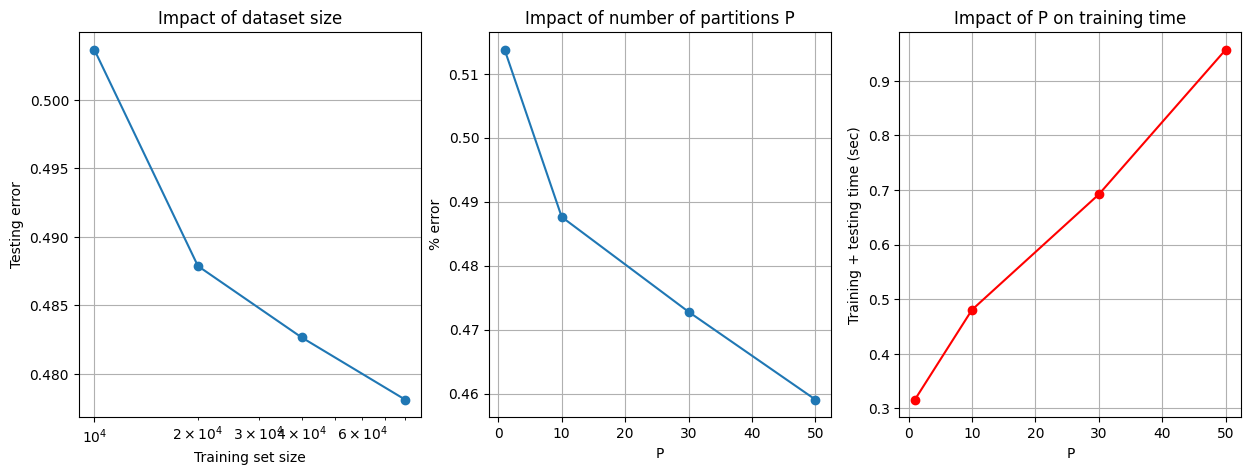

In [21]:
# Optimal parameters from the paper
gamma = 0.05  # Kernel parameter
alpha = 0.1   # Ridge regularization parameter

# 3. Testing the impact of dataset size on test error
dataset_sizes = [10000, 20000, 40000, 80000]  # Different sizes
errors = []

for size in dataset_sizes:
    X_train_subset, _, y_train_subset, _ = train_test_split(X_train, y_train, train_size=size, stratify=y_train, random_state=42)
    acc, _, _ = train_rbf_ridge(P=50, gamma=gamma, alpha=alpha, X_train=X_train_subset, y_train=y_train_subset, X_test=X_test, y_test=y_test)
    errors.append(1 - acc)  # Compute test error

# 4. Testing the impact of the number of partitions P on error
P_values = [1, 10, 30, 50]
errors_p = []
train_times_p = []

for P in P_values:
    acc, train_time, _ = train_rbf_ridge(P, gamma, alpha, X_train, y_train, X_test, y_test)
    errors_p.append(1 - acc)  # Compute test error
    train_times_p.append(train_time)

# 5. Displaying graphs
plt.figure(figsize=(15,5))

# Graph 1: Test error vs Dataset size
plt.subplot(1,3,1)
plt.plot(dataset_sizes, errors, marker='o', linestyle='-')
plt.xscale("log")
plt.xlabel("Training set size")
plt.ylabel("Testing error")
plt.title("Impact of dataset size")
plt.grid()

# Graph 2: Error vs P
plt.subplot(1,3,2)
plt.plot(P_values, errors_p, marker='o', linestyle='-')
plt.xlabel("P")
plt.ylabel("% error")
plt.title("Impact of number of partitions P")
plt.grid()

# Graph 3: Training time vs P
plt.subplot(1,3,3)
plt.plot(P_values, train_times_p, marker='o', linestyle='-', color='r')
plt.xlabel("P")
plt.ylabel("Training + testing time (sec)")
plt.title("Impact of P on training time")
plt.grid()

plt.show()